# Infer

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from tqdm import tqdm

from model.model import Transformer_fcst
from tools.infer import InferShortTerm, InferLongTerm
from tools.create_synthetic import create_multi
from tools.preprocess import make_input_target, make_src_tgt
from tools.train import make_loader

In [40]:
# infer config
src_len, tgt_len = 96, 24
run_name = 'confused-sweep-5'
project_name = 'transformer_for_time_series_synthetic_data'

# device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# test data
test_data = create_multi(1000, src_len, tgt_len)
input, target = make_input_target(test_data, src_len, tgt_len)
test_dloader = make_loader(input, target, batch_size=128)

In [41]:
# model (load .pth from checkpoints)
model = Transformer_fcst(fcst_mode='gauss',
                         seq_len=(src_len, tgt_len),
                         embedding_dim=16,
                         nhead=8,
                         num_layers=(2, 2),
                         device=device,
                         ts_embed='wavenet',
                         pos_embed='fixed').to(device)
model.load_state_dict(torch.load(
    f'./checkpoints/synthetic/{project_name}_{run_name}.pth'))
print(f'Load model from \n project name: {project_name} \n run name: {run_name}')

Load model from 
 project name: transformer_for_time_series_synthetic_data 
 run name: charmed-sweep-3


In [43]:
# infer objects
infershort = InferShortTerm(model)
inferlong = InferLongTerm(model)

## Short-term forecasting (i.e. rolling-timestep forecast)

### Eval

In [5]:
running_loss, running_metric = 0.0, 0.0
with torch.no_grad():
    for (input_batch, target_batch) in test_dloader:
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)
        src, tgt = make_src_tgt(input_batch, src_len, tgt_len)
        loss, metrics = infershort.eval((src,tgt), target_batch)

        running_loss += loss.item()
        running_metric += metrics[0].item()

print('Test loss:', running_loss / len(test_dloader))
print('Test metric(MAE):', running_metric / len(test_dloader))

Test loss: 0.82331333309412
Test metric(MAE): 1.0845548212528229


### Plot samples

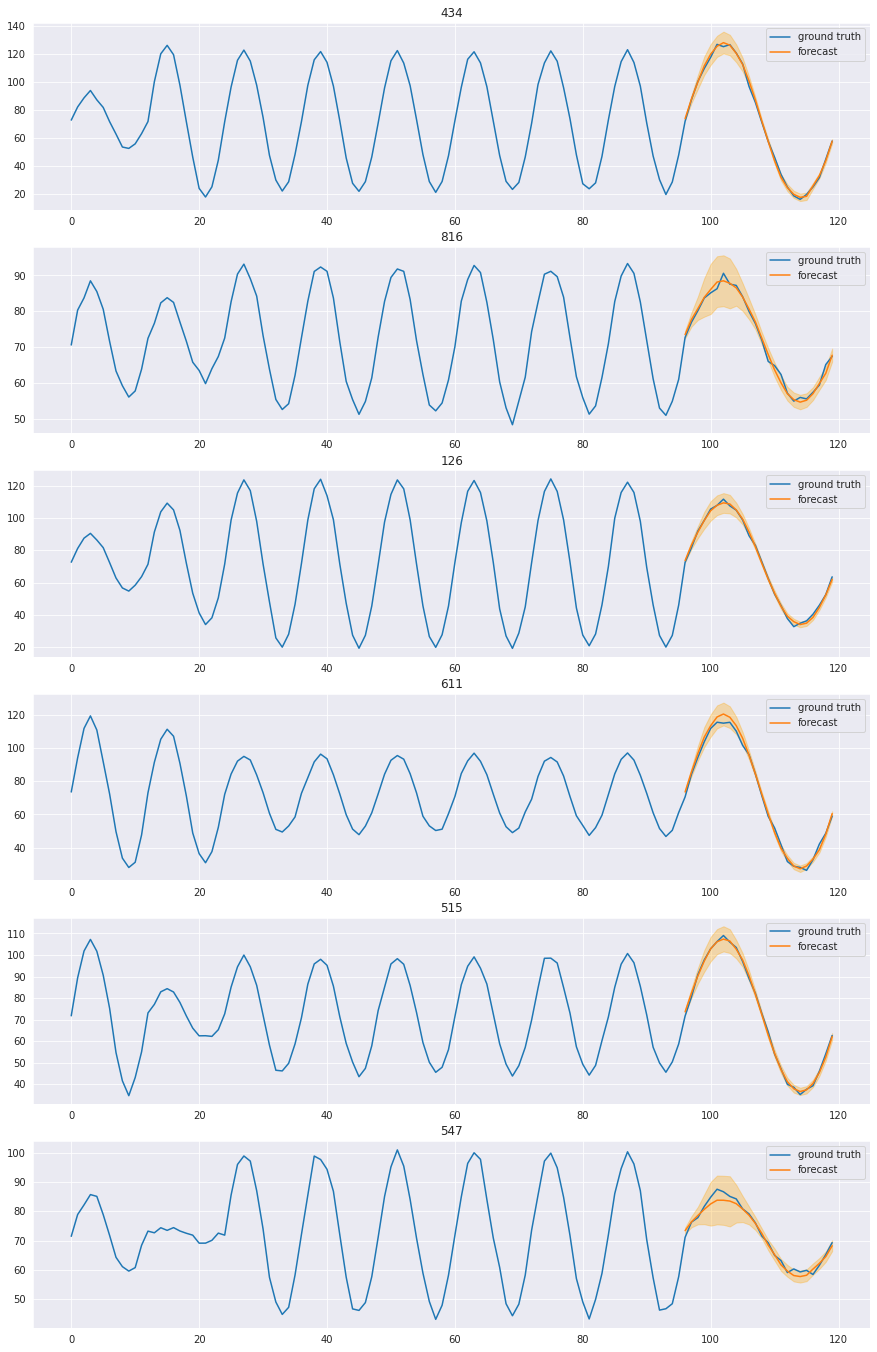

In [49]:
# canvas
fig, axes = plt.subplots(6,1, figsize=(15,24))

# sample indices (which are to be used again in long-term forecasting)
sample_idxs = np.random.choice(input.shape[0], len(axes), replace=False)

# sampling
input_sample, target_sample = input[sample_idxs], target[sample_idxs]
src, tgt = make_src_tgt(input_sample, src_len, tgt_len)

# plot
with torch.no_grad():
    src = torch.Tensor(src).to(device)
    tgt = torch.Tensor(tgt).to(device)
    target_sample = torch.Tensor(target_sample).to(device)
    infershort.plot((src,tgt), target_sample, axes)

# set index number as a title
for idx, ax in zip(sample_idxs, axes):
    ax.set_title(idx)

## Long-term forecasting (i.e. with recurrence)
> The code is identical to short-term forecasting. Only difference is to use InferLongTerm instead of InferShortTerm.

### Eval

In [8]:
running_loss, running_metric = 0.0, 0.0
with torch.no_grad():
    for (input_batch, target_batch) in tqdm(test_dloader):
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)
        src, tgt = make_src_tgt(input_batch, src_len, tgt_len)
        loss, metrics = inferlong.eval((src, tgt), target_batch)
        
        running_loss += loss.item()
        running_metric += metrics[0].item()

print('Test loss:', running_loss / len(test_dloader))
print('Test metric(MAE):', running_metric / len(test_dloader))


100%|██████████| 8/8 [00:26<00:00,  3.27s/it]

Test loss: 1.7099700421094894
Test metric(MAE): 1.7908066362142563


### Plot samples
> Sampes are same to short-term forecasting.

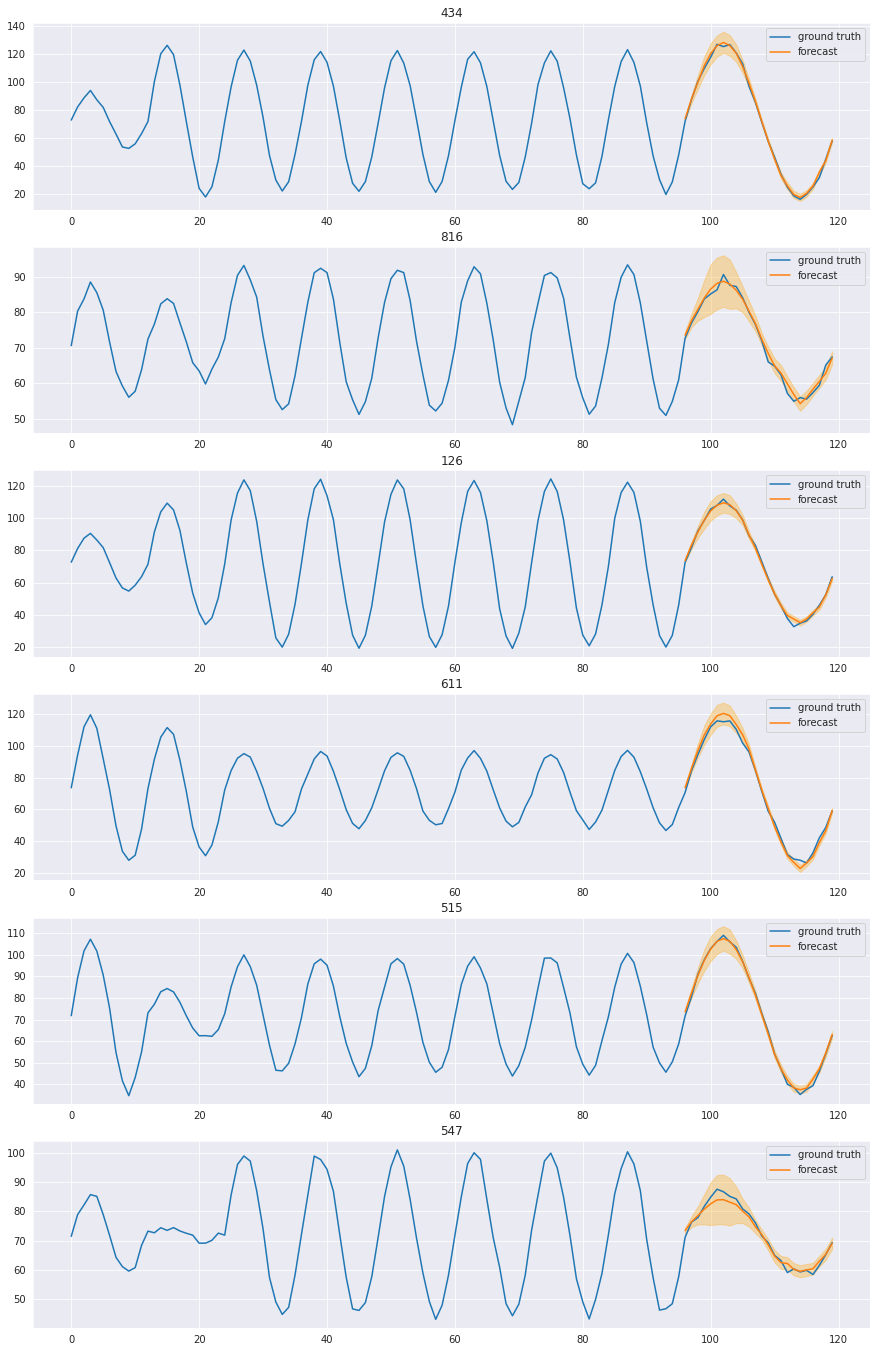

In [50]:
# canvas
fig, axes = plt.subplots(6, 1, figsize=(15, 24))

# sampling
input_sample, target_sample = input[sample_idxs], target[sample_idxs]
src, tgt = make_src_tgt(input_sample, src_len, tgt_len)

# plot
with torch.no_grad():
    src = torch.Tensor(src).to(device)
    tgt = torch.Tensor(tgt).to(device)
    target_sample = torch.Tensor(target_sample).to(device)
    inferlong.plot((src, tgt), target_sample, axes)

# set index number as a title
for idx, ax in zip(sample_idxs, axes):
    ax.set_title(idx)    
